In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import time
from timeit import default_timer
import time
from data_fno import MultiFunctionDatasetODE, custom_collate_ODE_fn 
from torch.utils.data import DataLoader
from datetime import datetime

In [4]:
class PR(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(PR, self).__init__()

        self.modes1 = modes1
        self.scale = (1 / (in_channels*out_channels))
        self.weights_pole = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
        self.weights_residue = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
   
    def output_PR(self, lambda1,alpha, weights_pole, weights_residue):   
        Hw=torch.zeros(weights_residue.shape[0],weights_residue.shape[0],weights_residue.shape[2],lambda1.shape[0], device=alpha.device, dtype=torch.cfloat)
        term1=torch.div(1,torch.sub(lambda1,weights_pole))
        Hw=weights_residue*term1
        Pk=-Hw  # for ode, Pk equals to negative Hw
        output_residue1=torch.einsum("bix,xiok->box", alpha, Hw) 
        output_residue2=torch.einsum("bix,xiok->bok", alpha, Pk) 
        return output_residue1,output_residue2    
    

    def forward(self, x):
        t=grid_x_train.cuda()
        #Compute input poles and resudes by FFT
        dt=(t[1]-t[0]).item()
        alpha = torch.fft.fft(x)
        lambda0=torch.fft.fftfreq(t.shape[0], dt)*2*np.pi*1j
        lambda1=lambda0.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        lambda1=lambda1.cuda()
        start=time.time()

        # Obtain output poles and residues for transient part and steady-state part
        output_residue1,output_residue2= self.output_PR(lambda1, alpha, self.weights_pole, self.weights_residue)

        # Obtain time histories of transient response and steady-state response
        x1 = torch.fft.ifft(output_residue1, n=x.size(-1))
        x1 = torch.real(x1)
        x2=torch.zeros(output_residue2.shape[0],output_residue2.shape[1],t.shape[0], device=alpha.device, dtype=torch.cfloat)    
        term1=torch.einsum("bix,kz->bixz", self.weights_pole, t.type(torch.complex64).reshape(1,-1))
        term2=torch.exp(term1) 
        x2=torch.einsum("bix,ioxz->boz", output_residue2,term2)
        x2=torch.real(x2)
        x2=x2/x.size(-1)
        return x1+x2

class LNO1d(nn.Module):
    def __init__(self, width,modes):
        super(LNO1d, self).__init__()

        self.width = width
        self.modes1 = modes
        self.fc0 = nn.Linear(2, self.width) 

        self.conv0 = PR(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self,x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x =  torch.sin(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Dataset parameters
n_functions = 1000000
grf_lb = 0.02
grf_ub = 0.5
end_time = 1.0
num_domain = 200
num_initial = 20
batch_size = 1024
m = 200

dataset = MultiFunctionDatasetODE(
    m=m,
    n_functions=n_functions,
    function_types=['grf', 'linear', 'sine', 'polynomial','constant'],
    end_time = end_time,
    num_domain = num_domain,
    num_initial = num_initial,
    grf_lb = grf_lb,
    grf_ub = grf_ub
)

dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=custom_collate_ODE_fn, shuffle=True)

In [55]:

learning_rate = 0.001
epochs = 1200
step_size = 100
gamma = 0.9

modes = 32
width = 8

# model
model = LNO1d(width,modes).cuda()

# ====================================
# Training 
# ====================================
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
start_time = time.time()

In [ ]:
def compute_loss(model, u, t):
    
    x = model(u)

    dt = dt=(t[1]-t[0]).item()

    dx_dt = (x[:, 1:, :] - x[:, :-1, :]) / dt  # crude finite diff
    residual = dx_dt + x[:, :-1, :] - u[:, :-1, :]

    physics_loss = torch.mean(residual ** 2)

    x0 = x[:, 0, :]
    initial_loss = torch.mean((x0 - 1.0)**2)

    return physics_loss, initial_loss


In [ ]:
timestop = 50

# Model setup
model = LNO1d(width,modes)
model.to(device)

model.load_state_dict(torch.load('epochs_[50]_model_time_[20250421-193502]_loss_[0.0044].pth'))

for ep in range(timestop, epochs):
    model.train()
    t1 = default_timer()
    epoch_loss = 0.0
    n_batches = 0

    for u, t, _, _ in dataloader:
        u = u.to(device).unsqueeze(-1)
        grid_x_train = t
        optimizer.zero_grad()
        physics_loss, initial_loss = compute_loss(model, u, grid_x_train)
        loss = physics_loss + initial_loss
        loss.backward()
        optimizer.step()
        print(f"Epoch: {ep}, Physics loss: {physics_loss}, Initial loss: {initial_loss}")
        epoch_loss += loss.item()
        n_batches += 1

    
    epoch_loss /= n_batches
    # Save model checkpoint
    if (ep + 1) % 10 == 0:
        timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
        model_filename = f'epochs_[{ep+1}]_model_time_[{timestamp}]_loss_[{epoch_loss:.4f}].pth'
        torch.save(model.state_dict(), f"trained_models/lno/{model_filename}")

    scheduler.step()



Epoch: 40, Physics loss: 0.003805998247116804, Initial loss: 0.0004054906021337956
Epoch: 40, Physics loss: 0.004056949634104967, Initial loss: 0.0004287818446755409
Epoch: 40, Physics loss: 0.0038791175466030836, Initial loss: 0.00042602751636877656
Epoch: 40, Physics loss: 0.0037415544502437115, Initial loss: 0.0004180392425041646
Epoch: 40, Physics loss: 0.00411637406796217, Initial loss: 0.00041967484867200255
Epoch: 40, Physics loss: 0.0036719348281621933, Initial loss: 0.0004215860099066049
Epoch: 40, Physics loss: 0.0038606137968599796, Initial loss: 0.00043862737948074937
Epoch: 40, Physics loss: 0.0039738076739013195, Initial loss: 0.0004126537824049592
Epoch: 40, Physics loss: 0.003691447898745537, Initial loss: 0.0004098447388969362
Epoch: 40, Physics loss: 0.004082785919308662, Initial loss: 0.00042904270230792463
Epoch: 40, Physics loss: 0.003560595214366913, Initial loss: 0.0004159238305874169
Epoch: 40, Physics loss: 0.0039926148019731045, Initial loss: 0.000421906006522

KeyboardInterrupt: 

In [117]:
# Model setup
model = LNO1d(width,modes)
model.to(device)

model.load_state_dict(torch.load('trained_models/lno/epochs_[30]_model_time_[20250421-184833]_loss_[0.0048].pth'))
model.eval()  #

LNO1d(
  (fc0): Linear(in_features=2, out_features=8, bias=True)
  (conv0): PR()
  (w0): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [152]:
def objective_function(n, args):

    x = args['x']
    u = args['u']
    t = args['t']


    dt = (t[0, 1] - t[0, 0]).item()
    dx_dt = (x[:, 1:, :] - x[:, :-1, :]) / dt  # crude finite diff
    residual = dx_dt + x[:, :-1, :] - u[:, :-1, :]

    physics_loss = torch.mean(residual ** 2)

    initial_loss = torch.mean((x[:, 0] - torch.ones(n, device=device))**2)
    control_cost = torch.mean(torch.trapz((x**2 + u**2).squeeze(), t.squeeze()))

    du_dt = (u[:, 2:, :] - 2 * u[:, 1:-1, :] + u[:, :-2, :]) / dt**2  # second derivative
    smooth_loss = torch.mean(du_dt ** 2)

    J = control_cost + physics_loss + initial_loss 
    return J


# ------------------------
# Gradient Descent Routine (Batched Version)
# ------------------------
def gradient_descent(n, alpha, m, num_epochs, model, objective_function):  
    
    u = (0.2 * torch.randn(1, m, device=device)).unsqueeze(-1)  # shape = (1, m, 1)
    t = torch.linspace(0, end_time, m, device= device).unsqueeze(1).T 
    u.requires_grad_(True)

    optimizer = torch.optim.Adam([u], lr=alpha)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

    for epoch in range(num_epochs):

        optimizer.zero_grad()
        x = model(u)

        args = {'u': u, 't': t, 'x':x}
        loss = objective_function(n, args)
        loss.backward()
        optimizer.step()


        if (epoch+1) % 100 == 0:
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, time: {datetime.now().time()}')
       

    return u, x, t

In [153]:

# ------------------------
# Hyperparameters and Model Loading
# ------------------------
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n = 1      # Batch size (number of random functions)
m = 200       # Number of time points (sensors)
num_epochs = 5000
alpha = 0.001

# (Assume your FNO model class definition is available)
# Instantiate and load your trained FNO model.
#trained_model = FNO(input_net, fourier_layers_config, output_net,
                    #, output_activations, fourier_activation)
#trained_model.to(device)
#trained_model.load_state_dict(torch.load('trained_models/fno/epochs_[29]_model_time_[20250317-233106]_loss_[0.0022].pth', map_location=device))
#trained_model.eval()

# ------------------------
# Run Gradient Descent to Optimize u
# ------------------------
u_opt, x_opt, t = gradient_descent(n, alpha, m, num_epochs, model, objective_function)
print("Optimized control u(t):", u_opt)


Epoch [100/5000], Loss: 0.4556, time: 19:46:57.080103
Epoch [200/5000], Loss: 0.4341, time: 19:46:57.432001
Epoch [300/5000], Loss: 0.4221, time: 19:46:57.783099
Epoch [400/5000], Loss: 0.4154, time: 19:46:58.134045
Epoch [500/5000], Loss: 0.4116, time: 19:46:58.484562
Epoch [600/5000], Loss: 0.4096, time: 19:46:58.834854
Epoch [700/5000], Loss: 0.4085, time: 19:46:59.185461
Epoch [800/5000], Loss: 0.4079, time: 19:46:59.536025
Epoch [900/5000], Loss: 0.4076, time: 19:46:59.891291
Epoch [1000/5000], Loss: 0.4074, time: 19:47:00.246746
Epoch [1100/5000], Loss: 0.4074, time: 19:47:00.596786
Epoch [1200/5000], Loss: 0.4073, time: 19:47:00.947301
Epoch [1300/5000], Loss: 0.4073, time: 19:47:01.297390
Epoch [1400/5000], Loss: 0.4073, time: 19:47:01.647437
Epoch [1500/5000], Loss: 0.4073, time: 19:47:01.997857
Epoch [1600/5000], Loss: 0.4073, time: 19:47:02.348186
Epoch [1700/5000], Loss: 0.4073, time: 19:47:02.698581
Epoch [1800/5000], Loss: 0.4073, time: 19:47:03.048460
Epoch [1900/5000], 

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# Define analytical solutions using NumPy (if not defined yet)
def analytical_x(t):
    numerator = np.sqrt(2) * np.cosh(np.sqrt(2) * (t - 1)) - np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

def analytical_u(t):
    numerator = np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

# Create a time grid for plotting. Here t_plot is a NumPy array of shape (m,)
t_plot = np.linspace(0, end_time, m)

# Compute analytical solutions.
analytical_x_vals = analytical_x(t_plot)
analytical_u_vals = analytical_u(t_plot)


In [155]:
u_tensor = torch.from_numpy(analytical_u_vals).float().unsqueeze(0).to(device)  # shape [1, 200]

model(u_tensor.unsqueeze(-1)).reshape(200)

tensor([1.0177, 1.0106, 1.0040, 0.9972, 0.9906, 0.9839, 0.9774, 0.9708, 0.9644,
        0.9579, 0.9516, 0.9452, 0.9389, 0.9326, 0.9263, 0.9201, 0.9140, 0.9078,
        0.9018, 0.8957, 0.8898, 0.8838, 0.8779, 0.8720, 0.8662, 0.8604, 0.8546,
        0.8489, 0.8432, 0.8376, 0.8320, 0.8264, 0.8209, 0.8154, 0.8099, 0.8045,
        0.7991, 0.7938, 0.7885, 0.7832, 0.7780, 0.7728, 0.7677, 0.7626, 0.7575,
        0.7524, 0.7475, 0.7425, 0.7375, 0.7326, 0.7278, 0.7229, 0.7181, 0.7134,
        0.7087, 0.7040, 0.6993, 0.6947, 0.6901, 0.6855, 0.6810, 0.6765, 0.6721,
        0.6677, 0.6633, 0.6589, 0.6546, 0.6503, 0.6460, 0.6418, 0.6376, 0.6334,
        0.6293, 0.6252, 0.6211, 0.6171, 0.6130, 0.6091, 0.6051, 0.6012, 0.5973,
        0.5934, 0.5896, 0.5858, 0.5820, 0.5782, 0.5745, 0.5708, 0.5671, 0.5635,
        0.5599, 0.5563, 0.5528, 0.5492, 0.5457, 0.5422, 0.5388, 0.5354, 0.5320,
        0.5286, 0.5253, 0.5220, 0.5186, 0.5154, 0.5121, 0.5089, 0.5057, 0.5026,
        0.4994, 0.4963, 0.4932, 0.4901, 

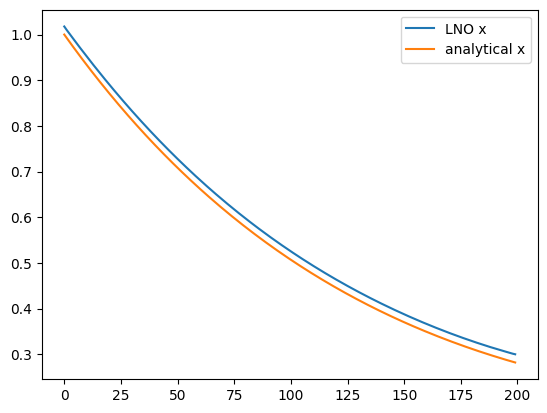

In [156]:
u_tensor = torch.from_numpy(analytical_u_vals).float().unsqueeze(0).to(device)  # shape [1, 200]

plt.plot(model(u_tensor.unsqueeze(-1)).reshape(200).cpu().detach().numpy(), label="LNO x")
plt.plot(analytical_x_vals, label="analytical x")
plt.legend()
plt.show()

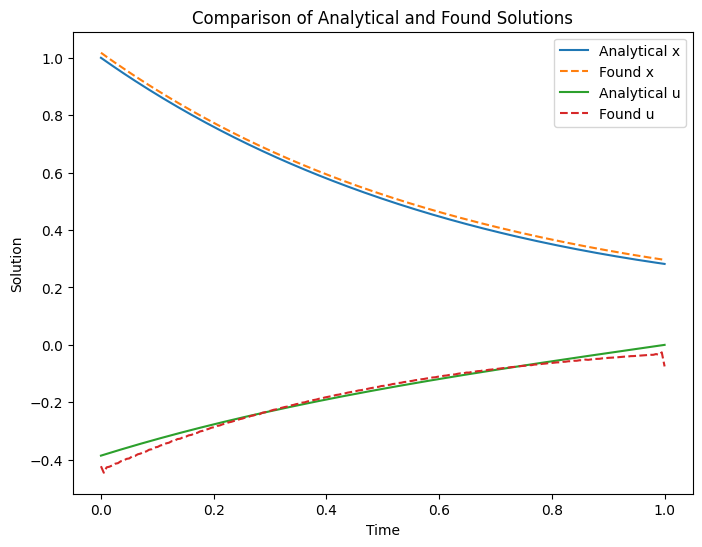

In [157]:
# Prepare inputs for the FNO model.
# u_opt is assumed to be the optimized control (1D tensor of shape (m,))
# We create a time tensor of shape (1, m) and a control tensor of shape (1, m)

x_found = x_opt.cpu().detach().numpy()# Flatten to shape (m,)
u_found = u_opt.cpu().detach().numpy()  # Already shape (m,)

# Plot the results.
plt.figure(figsize=(8, 6))
plt.plot(t_plot, analytical_x_vals, label="Analytical x")
plt.plot(t_plot, x_found.reshape(200), label="Found x", linestyle='--')
plt.plot(t_plot, analytical_u_vals, label="Analytical u")
plt.plot(t_plot, u_found.reshape(200), label="Found u", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Solution")
plt.legend()
plt.title("Comparison of Analytical and Found Solutions")
plt.show()